In [1]:
import sys
sys.path.append('../../')
import config as cf

import tensorflow as tf
import keras.backend.tensorflow_backend
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.65)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(session)

from keras.layers import Input, Dense
from keras.models import Model
from data import main, generate_data
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.models import model_from_json
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

import random

Using TensorFlow backend.


In [2]:
df_1=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group01.xlsx')
df_2=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group02.xlsx')
df_3=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group03.xlsx')
df_4=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group04.xlsx')
df_5=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group05.xlsx')
df_6=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group06.xlsx')
df_7=pd.read_excel(cf.DATA_CONFIG['data_folder'] + 'group/group07.xlsx')
df_3=df_3.reset_index()
#df_5=df_5.dropna()
#df_5=df_5.reset_index()
df_7=df_7.dropna()
df_7=df_7.reset_index()

In [3]:
a_1 = (preprocessing.scale(df_1['Asymmetry_1_1']) + preprocessing.scale(df_1['Asymmetry_1_2']) + preprocessing.scale(df_1['Asymmetry_1_3']))/3.0
a_2 = (preprocessing.scale(df_2['Asymmetrie']) + preprocessing.scale(df_2['Unnamed: 3']) + preprocessing.scale(df_2['Unnamed: 4']))/3.0
a_3 = (preprocessing.scale(df_3['Asymmetry_3_1']) + preprocessing.scale(df_3['Asymmetry_3_2']) + preprocessing.scale(df_3['Asymmetry_3_3']))/3.0
a_4 = (preprocessing.scale(df_4['Asymmetry_4_1']) + preprocessing.scale(df_4['Asymmetry_4_3']) + preprocessing.scale(df_4['Asymmetry_4_5']))/3.0
a_5 = (preprocessing.scale(df_5['Asymmetry_5_1']) + preprocessing.scale(df_5['Asymmetry_5_2']) + preprocessing.scale(df_5['Asymmetry_5_3']))/3.0
a_6 = (preprocessing.scale(df_6['Asymmetry_6_1']) + preprocessing.scale(df_6['Asymmetry_6_2'])+ preprocessing.scale(df_6['Asymmetry_6_3']))/3.0
a_7 = (preprocessing.scale(df_7['Asymmetry_7_1']) + preprocessing.scale(df_7['Asymmetry_7_2']) + preprocessing.scale(df_7['Asymmetry_7_3']) + preprocessing.scale(df_7['Asymmetry_7_4']) + preprocessing.scale(df_7['Asymmetry_7_5']) + preprocessing.scale(df_7['Asymmetry_7_6']))/6.0

/home/reuben/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [4]:
#Image filename list and label for asymmetry
asymm_label=np.concatenate((a_1, a_2, a_3, a_4,a_5, a_6, a_7))
asymm_id=np.concatenate((df_1['ID'],df_2['Afbeelding'],df_3['index'],df_4['ID'],df_5['ID'], df_6['ID'],df_7['ID'])) 
#Image filename list and label for class
df=pd.read_csv(cf.DATA_CONFIG['data_folder'] + 'csv/ISIC-2017_Training_Part3_GroundTruth.csv')
class_label=df['melanoma']
class_id=df['image_id']



In [5]:

class_id_=[]
class_label_=[]

#Shuffle dataset
indexes=list(range(len(class_id)))
random.Random(4).shuffle(indexes)	#To produce same train and valid set every time. Instead of Random(4) DO NOT use seed=4, because it will pollute randomness of the rest of the program.
for index in indexes:
    class_id_.append(class_id[index])
    class_label_.append(class_label[index])

train_id=class_id_[:-600]	#1400 training
train_label_c=class_label_[:-600]

valid_id=class_id_[1400:1750]	#350 valid
valid_label_c=class_label_[1400:1750]
test_id=class_id_[1750:]	#250 test
test_label_c=class_label_[1750:]

In [6]:
#Data Generator

def generate_data(directory, augmentation, shuffle, batch_size, file_list, label_1):
	i=0
	shuff_file_list=file_list
	shuff_label_1=label_1

	while True:
		image_batch=[]
		label_1_batch=[]
		for b in range(batch_size):
			if i==(len(file_list)):
				i=0
				if shuffle==True:
					new_file_list=[]
					new_label_1=[]
					indexes=list(range(len(shuff_file_list)))
					random.shuffle(indexes)
					for index in indexes:
						new_file_list.append(shuff_file_list[index])
						new_label_1.append(shuff_label_1[index])
					shuff_file_list=new_file_list
					shuff_label_1=new_label_1
	
			img=image.load_img(directory+shuff_file_list[i]+'.jpg', grayscale=False, target_size=(384,384))
			img = image.img_to_array(img)
			if augmentation==True:
				datagen = ImageDataGenerator(
						    rotation_range=360,
						    width_shift_range=0.1,
						    height_shift_range=0.1,
						    shear_range=0.2,
						    zoom_range=0.2,
						    channel_shift_range=20,
						    horizontal_flip=True,
						    vertical_flip=True,
						    fill_mode = "nearest")
				img=datagen.random_transform(img)
				img=img/255.0

			if augmentation==False:
				img=img/255.0
			image_batch.append(img)
			label_1_batch.append(shuff_label_1[i])		
			i=i+1
		
		yield(np.asarray(image_batch), np.asarray(label_1_batch))

In [7]:
direc = cf.DATA_CONFIG['data_folder'] + 'image_data/'

bs = 10
train=generate_data(directory=direc, augmentation=True, shuffle=True, batch_size=bs, file_list=train_id, label_1=train_label_c)

validation=generate_data(directory=direc, augmentation=False, shuffle=True, batch_size=bs, file_list=valid_id, label_1=valid_label_c)


In [8]:
#Build the model
img_height, img_width, img_channel=384,384,3
input_tensor     = Input(shape=(img_height, img_width, img_channel))
vgg_new_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(img_height, img_width, img_channel), pooling='avg')
for layer in vgg_new_model.layers[:-5]:
    layer.trainable = False
result=Dense(100, activation='relu')(vgg_new_model.output)
result=Dense(100, activation='relu')(result)
result=Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(result)
model= Model(inputs=vgg_new_model.input, outputs=result)

#Check the model
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 384, 384, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 96, 128)       0         
__________

In [9]:
opt=keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)


In [ ]:
tfdir = cf.DATA_CONFIG['project_folder'] + 'logs/classification/'
bs=10
tensorboard = TensorBoard(log_dir=tfdir, write_graph=True)
callbacks = [tensorboard]

history=model.fit_generator(train,steps_per_epoch=(len(train_id)//bs),epochs=200,validation_steps=10,validation_data=validation,class_weight={0:1.,1:5.},
callbacks=callbacks)




Epoch 1/200
140/140 [==============================] - 29s - loss: 1.1317 - acc: 0.5957 - val_loss: 0.9777 - val_acc: 0.2400
Epoch 2/200
140/140 [==============================] - 30s - loss: 1.1638 - acc: 0.6079 - val_loss: 0.6402 - val_acc: 0.7900
Epoch 3/200
140/140 [==============================] - 30s - loss: 1.1680 - acc: 0.6064 - val_loss: 0.8879 - val_acc: 0.4200
Epoch 4/200
 27/140 [====>.........................] - ETA: 22s - loss: 1.1281 - acc: 0.6556

In [14]:
#save model to JSON
model_json = model.to_json()
with open(cf.DATA_CONFIG['project_folder'] + "weights/classification.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights(cf.DATA_CONFIG['project_folder'] + "weights/classification.h5")
print("Saved model to disk")

Saved model to disk


In [15]:
test=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=False, shuffle=False, batch_size=10, file_list=test_id, label_1=test_label_c)

In [16]:
#Load model
json_file = open(cf.DATA_CONFIG['project_folder'] + 'weights/classification.json', 'r')
model_json = json_file.read()
json_file.close()
load_model = model_from_json(model_json)
#Load weights into new model
load_model.load_weights(cf.DATA_CONFIG['project_folder'] + "weights/classification.h5")
print("Loaded model from disk")

Loaded model from disk


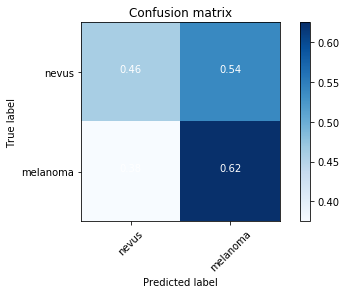

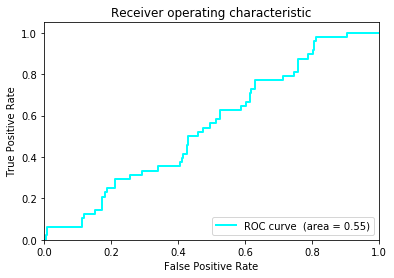

In [19]:
#Make prediction for class
y_pred = load_model.predict_generator(test, steps=25)
y_pred_c=np.array(y_pred)
y_true=test_label_c



In [20]:
#Confusion matrix
classes={'nevus': 0, 'melanoma': 1}
thre=0.5
# obtain class predictions from probabilities
y_predi=(y_pred_c>=thre)*1
# obtain (unnormalized) confusion matrix
cm = confusion_matrix(y_true, y_predi)
# normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]




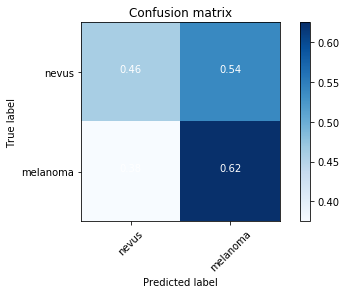

In [21]:
# Plotting the Confusion matrix

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
	plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

#Saving the above plot to the directory specified
plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/Classification_Confusion_Matrix.png')


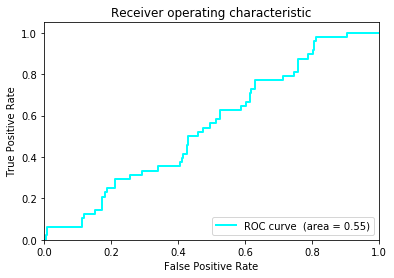

In [22]:
#Plotting ROC curve and score
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='aqua', lw=2,
label='ROC curve  (area = {f:.2f})'.format( f=roc_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/Classification_ROC_Plot.png')

In [25]:
# End of the Interactive notebook